In [38]:
# 读取数据

import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data= pd.read_csv("E:\Pycharm\Intrusion_Detection\kddcup.data_10_percent.csv",  header=None,names = col_names)
data.head()
#去重
data_1=data.drop_duplicates()
# print(data_1.info())
#one-hot
dummies_protocol = pd.get_dummies(data_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_1["flag"], prefix='flag')
data_2 = pd.concat([data_1, dummies_protocol,dummies_flag], axis=1)
#去除neptune
data_3=data_2.copy()
data_4=data_3.drop(data_3[data_3.label=="neptune."].index)

In [39]:
#建立X,y
feature=["duration",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted",
    "num_access_files","num_outbound_cmds",
    "is_guest_login","rerror_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR","flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
   
X_1=data_4[feature]
y_1=data_4['label'].copy()   #一维

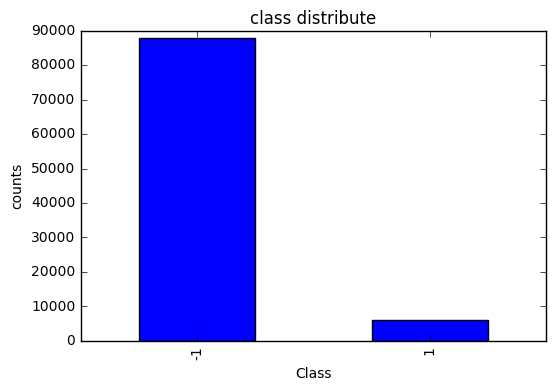

In [40]:
##y的处理
y_1[y_1!="normal."]='1'
y_1[y_1=="normal."]='-1'
y_1=y_1.astype(int)
import matplotlib.pyplot as plt
plt.figure() 
y_1.value_counts().plot(kind="bar")
plt.title("class distribute")
plt.xlabel("Class")
plt.ylabel("counts")
plt.show()

In [41]:
y_1.dtype

dtype('int32')

In [42]:
#标准化
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X_1)
X=scaler.transform(X_1)  #X是ndarray
#分类器
from sklearn.ensemble import IsolationForest
clf_1 = IsolationForest()
##模型评估
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_1, X, y_1, cv=10, scoring='accuracy')
print(scores.mean())
# 查看分类错误样本
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_1,test_size=0.2,random_state=0)  #切分样本
clf_1.fit(X_train)
preditions=clf_1.predict(X_test)

from  sklearn.metrics import accuracy_score
acc=accuracy_score(preditions,y_test) #计算accuracy
print(acc)

0.102172646855


0.0892609576624


In [43]:
print("scores.mean is %.6f" %(1-scores.mean()))
print(1-acc)

scores.mean is 0.897827
0.910739042338


In [44]:
#学习曲线
import numpy as np
from sklearn.model_selection import learning_curve
train_sizes,train_scores,test_scores=learning_curve(estimator=clf_1,
                                X=X_train,y=y_train,
                                train_sizes=np.linspace(0.1,1,10),
                                 cv=10, n_jobs=1,random_state=0,scoring='accuracy')
train_mean=np.mean(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_std=np.std(train_scores,axis=1)
import matplotlib.pyplot as plt

plt.grid()
plt.plot(train_sizes,1-train_mean,color='blue',marker='o',markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes,1-train_mean+train_std,1-train_mean-train_std,
         color='blue',alpha=0.25)
plt.plot(train_sizes,1-test_mean,color='green',linestyle='--',
         marker='s',markersize=5,
         label='balidation accuracy')
plt.fill_between(train_sizes,1-test_mean+test_std,1-test_mean-test_std,
         color='green',alpha=0.25)
# plt.figure()
# plt.ylim(0.5,0.9)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim(0.5,0.95)
plt.show()

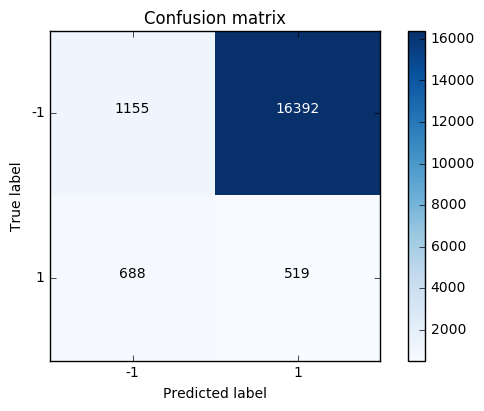

In [45]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#混淆矩阵
import itertools
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test,preditions)
class_names=['-1','1']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix')
plt.show()

In [79]:
#分类报告
from sklearn.metrics import classification_report
class_names=['-1','1']
print(classification_report(y_test,preditions,target_names=class_names,digits=6))

             precision    recall  f1-score   support

         -1   0.626696  0.065823  0.119134     17547
          1   0.030690  0.429992  0.057291      1207

avg / total   0.588337  0.089261  0.115153     18754



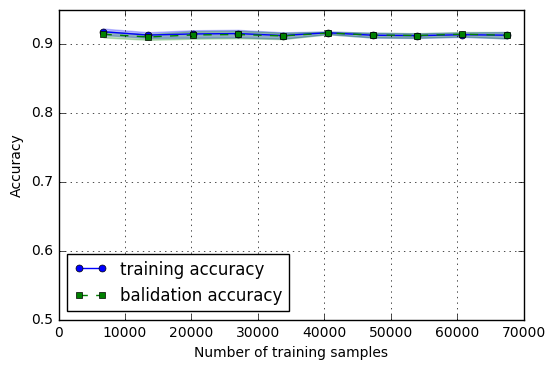

In [76]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(train_sizes,1-train_mean,color='blue',marker='o',markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes,1-train_mean+train_std,1-train_mean-train_std,
         color='blue',alpha=0.25)
plt.plot(train_sizes,1-test_mean,color='green',linestyle='--',
         marker='s',markersize=5,
         label='balidation accuracy')
plt.fill_between(train_sizes,1-test_mean+test_std,1-test_mean-test_std,
         color='green',alpha=0.25)
# plt.figure()
# plt.ylim(0.5,0.9)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim(0.5,0.95)
plt.show()